In [1]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
import tiktoken

# Count the number of tokens in each page_content
def num_tokens_from_string(string: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding("cl100k_base")
    num_tokens = len(encoding.encode(string, disallowed_special=()))
    return num_tokens

In [2]:
with open('../data/wikitexts.md', 'r') as file:
    corpus = file.read()

In [3]:
min_chunk_size = 50
splitter = RecursiveCharacterTextSplitter(
    chunk_size=min_chunk_size,
    chunk_overlap=0,
    length_function=num_tokens_from_string
    )

In [16]:
sentences = splitter.split_text(corpus)

In [5]:
len(sentences)

661

In [17]:
from openai import OpenAI
import os
import numpy as np

OPENAI_API_KEY = os.getenv('OPENAI_CHROMA_API_KEY')
client = OpenAI(api_key=OPENAI_API_KEY)

# response = client.embeddings.create(
#     input=docs,
#     model="text-embedding-3-large"
# )

In [19]:
def similarity_check(current_chunk, next_chunk) -> bool:
    response = client.embeddings.create(
        input=[current_chunk, next_chunk],
        model="text-embedding-3-large"
    )

    embedding1 = response.data[0].embedding
    embedding2 = response.data[1].embedding

    cosine_similarity = np.dot(embedding1, embedding2) / (np.linalg.norm(embedding1) * np.linalg.norm(embedding2))
    if cosine_similarity > 0.8:
        return True
    
    # if len(current_chunk) < 200:
    #     return True
    return False
    # return tiktoken.similarity(current_chunk, next_chunk, "cl100k_base"

sentences = splitter.split_text(corpus)
sentences = list(reversed(sentences))

docs = []
total_sentences = len(sentences)
current_chunk = sentences.pop()
while sentences:
    next_chunk = sentences.pop()
    if similarity_check(current_chunk, next_chunk):
        current_chunk += next_chunk
    else:
        docs.append(current_chunk)
        current_chunk = next_chunk
    progress = (total_sentences - len(sentences)) / total_sentences * 100
    print(f"Progress: {progress:.2f}%")
docs.append(current_chunk)

Progress: 0.30%
Progress: 0.45%
Progress: 0.61%
Progress: 0.76%
Progress: 0.91%
Progress: 1.06%
Progress: 1.21%
Progress: 1.36%
Progress: 1.51%
Progress: 1.66%
Progress: 1.82%
Progress: 1.97%
Progress: 2.12%
Progress: 2.27%
Progress: 2.42%
Progress: 2.57%
Progress: 2.72%
Progress: 2.87%
Progress: 3.03%
Progress: 3.18%
Progress: 3.33%
Progress: 3.48%
Progress: 3.63%
Progress: 3.78%
Progress: 3.93%
Progress: 4.08%
Progress: 4.24%
Progress: 4.39%
Progress: 4.54%
Progress: 4.69%
Progress: 4.84%
Progress: 4.99%
Progress: 5.14%
Progress: 5.30%
Progress: 5.45%
Progress: 5.60%
Progress: 5.75%
Progress: 5.90%
Progress: 6.05%
Progress: 6.20%
Progress: 6.35%
Progress: 6.51%
Progress: 6.66%
Progress: 6.81%
Progress: 6.96%
Progress: 7.11%
Progress: 7.26%
Progress: 7.41%
Progress: 7.56%
Progress: 7.72%
Progress: 7.87%
Progress: 8.02%
Progress: 8.17%
Progress: 8.32%
Progress: 8.47%
Progress: 8.62%
Progress: 8.77%
Progress: 8.93%
Progress: 9.08%
Progress: 9.23%
Progress: 9.38%
Progress: 9.53%
Progress

KeyboardInterrupt: 

In [25]:
sentences = splitter.split_text(corpus)

response = client.embeddings.create(
    input=sentences,
    model="text-embedding-3-large"
)

N = len(sentences)
embedding_matrix = np.zeros((N, len(response.data[0].embedding)))

# Populate the embedding matrix
for i, embedding_obj in enumerate(response.data):
    embedding = np.array(embedding_obj.embedding)
    embedding_matrix[i] = embedding

dot_product_matrix = np.dot(embedding_matrix, embedding_matrix.T)

In [26]:
neighbour_similarities = []
for i in range(N-1):
    neighbour_similarities.append(dot_product_matrix[i, i+1])

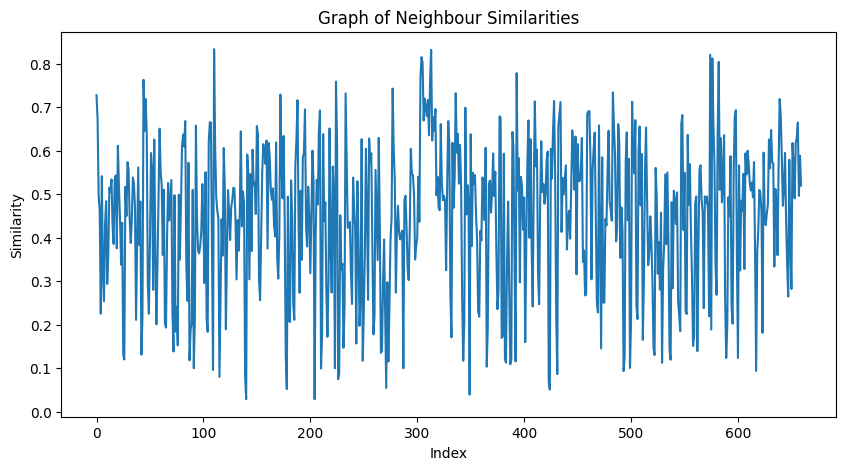

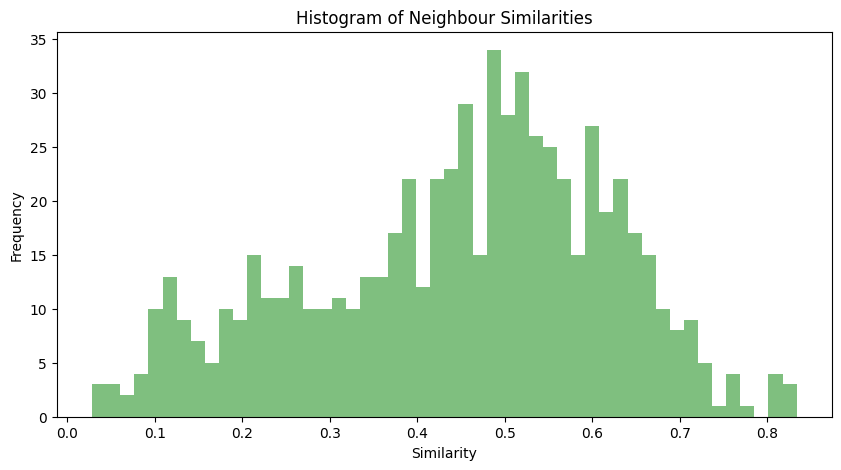

Mean of Neighbour Similarities: 0.44666487064967847
Median of Neighbour Similarities: 0.47653702286607
Min of Neighbour Similarities: 0.028338573562017914
Max of Neighbour Similarities: 0.8333918972686637
Standard Deviation of Neighbour Similarities: 0.17207791850940965


In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting the graph of neighbour_similarities
plt.figure(figsize=(10, 5))
plt.plot(neighbour_similarities)
plt.title('Graph of Neighbour Similarities')
plt.xlabel('Index')
plt.ylabel('Similarity')
plt.show()

# Plotting the histogram of neighbour_similarities
plt.figure(figsize=(10, 5))
plt.hist(neighbour_similarities, bins=50, alpha=0.5, color='g')
plt.title('Histogram of Neighbour Similarities')
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.show()

# Calculating and printing the mean, median, min, max and std of neighbour_similarities
mean_val = np.mean(neighbour_similarities)
median_val = np.median(neighbour_similarities)
min_val = np.min(neighbour_similarities)
max_val = np.max(neighbour_similarities)
std_val = np.std(neighbour_similarities)

print(f"Mean of Neighbour Similarities: {mean_val}")
print(f"Median of Neighbour Similarities: {median_val}")
print(f"Min of Neighbour Similarities: {min_val}")
print(f"Max of Neighbour Similarities: {max_val}")
print(f"Standard Deviation of Neighbour Similarities: {std_val}")


# Goals
1. Re-visit Greg's algorithm. Fully understand it.
2. Assess how it can be modify to deal with large texts and chunk max sizes.
3. Consider how we can then do a pinecone style one.